In [48]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
from nixtla import NixtlaClient
from tqdm.notebook import tqdm

In [49]:
# Initialize TimeGPT
API_KEY = "nixak-fDHJF9pfGpbvHEXbPqVGTwqIgBzv6xgDt4cJzqyjkj7ZAqFVue636fBAZZ5oqM57op6szHjbdTrUxbLg"  # Replace with your TimeGPT API Key

In [50]:
nixtla_client = NixtlaClient(
    api_key = API_KEY
)

In [51]:
nixtla_client.validate_api_key()

INFO:nixtla.nixtla_client:Happy Forecasting! :)


True

In [52]:
# Load the data using cuDF
data = pd.read_csv('../data/processed/inventory.csv')

In [53]:
# Filter data based on 'Material' Type and 'BFP' being 0
data = data[(data['Type'] == 'Material') & (data['BFP'] == 0)].copy()

# Convert the 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'])

data.sort_values('Date', inplace=True)

In [54]:
features = ['Material Code', 'Date', 'Material Issued']

df = data[features].copy()

In [55]:
df.rename({'Material Code': 'unique_id', 'Date': 'ds', 'Material Issued': 'y'}, inplace=True, axis=1)
df.head()

,unique_id,ds,y
8976,10091532,2023-01-01,0.0
8784,10024373,2023-01-01,0.0
8783,10024372,2023-01-01,0.0
8782,10024297,2023-01-01,0.0
8772,10023865,2023-01-01,0.0


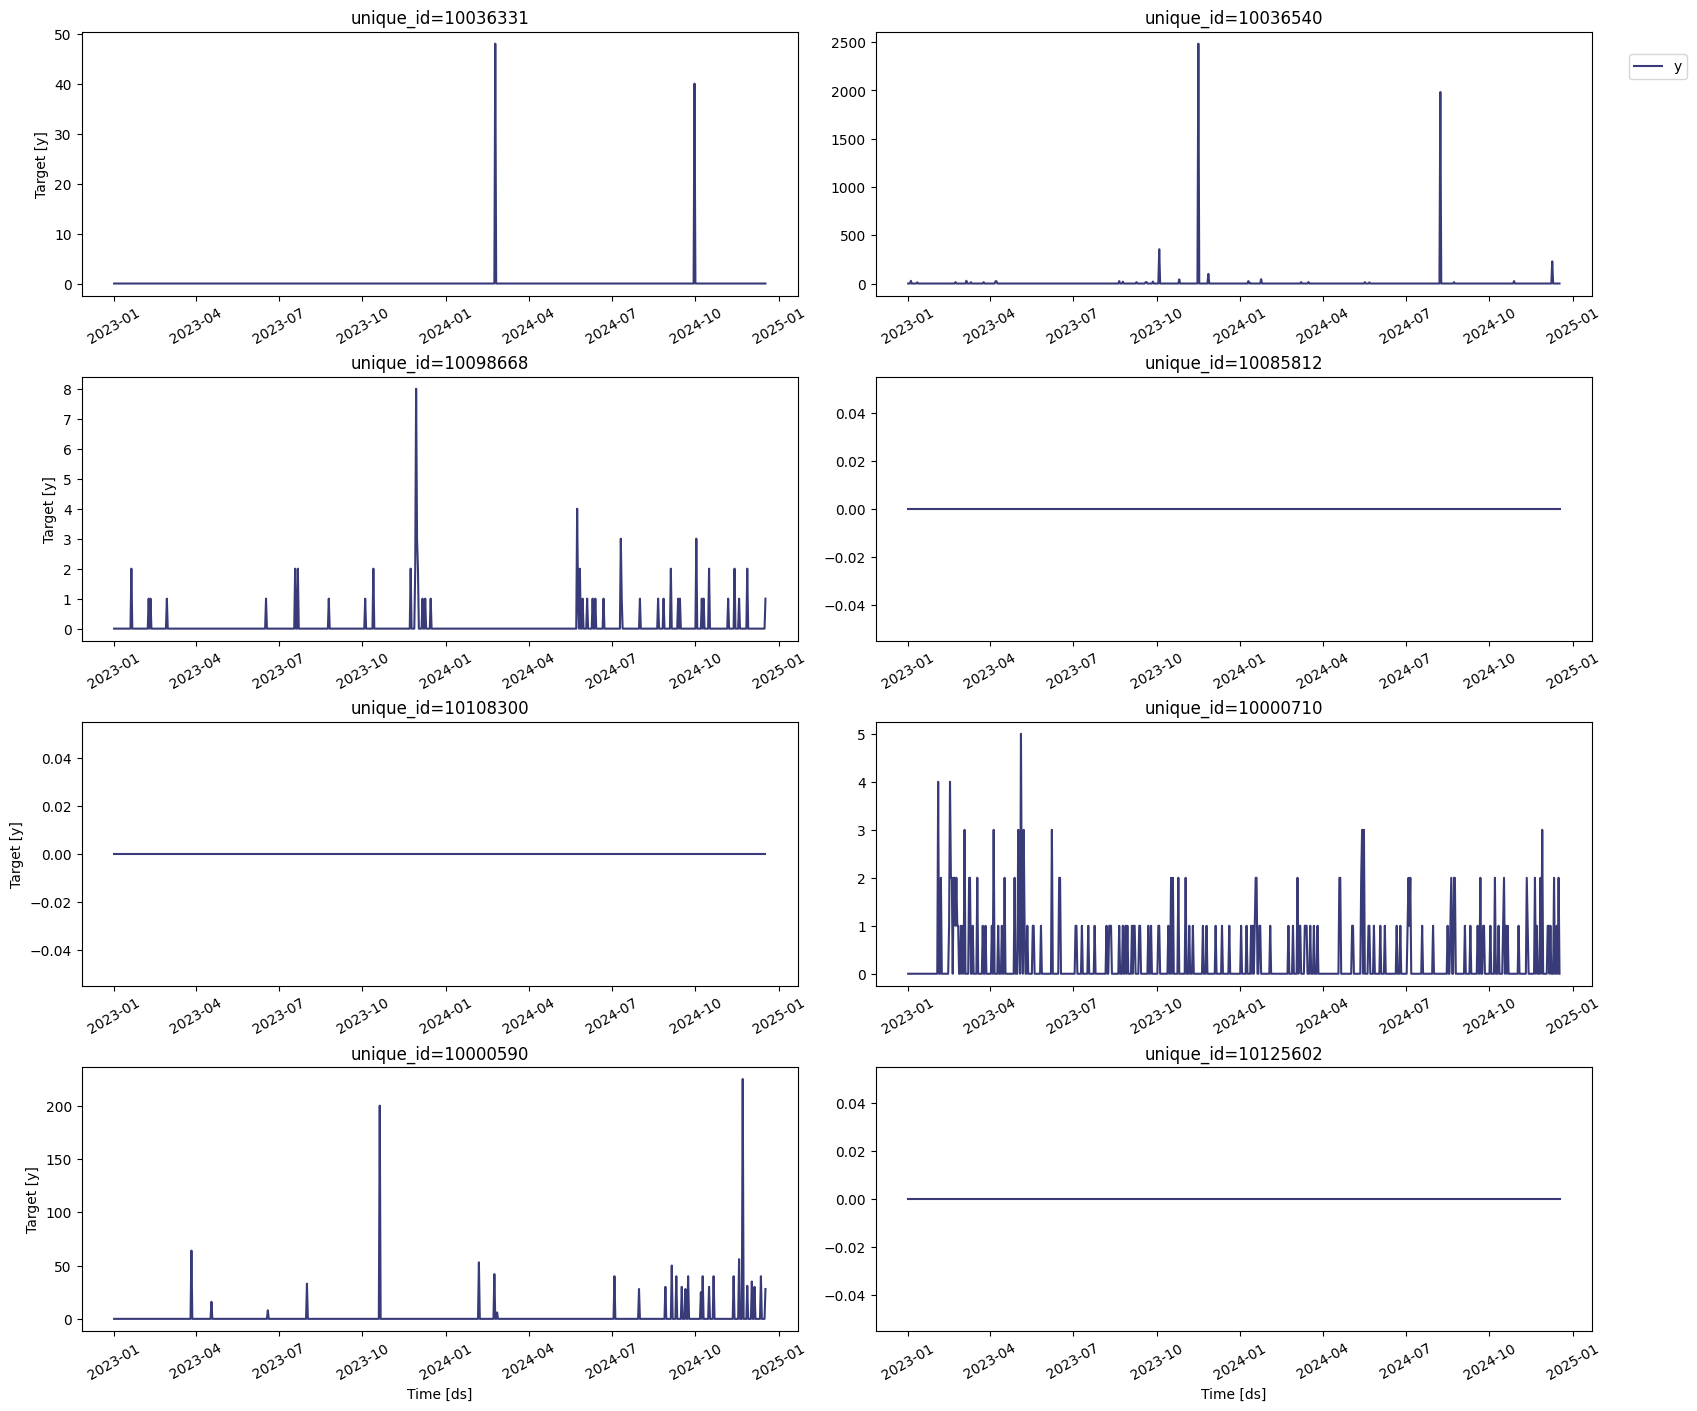

In [56]:
nixtla_client.plot(df)

In [57]:
timegpt_fcst_multiseries_df = nixtla_client.forecast(df=df, h=30, level=[80, 90])
timegpt_fcst_multiseries_df.head()

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: D
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Querying model metadata...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


,unique_id,ds,TimeGPT,TimeGPT-hi-80,TimeGPT-hi-90,TimeGPT-lo-80,TimeGPT-lo-90
0,10000033,2024-12-18,1.190778,2.353881,2.368542,0.027674,0.013013
1,10000033,2024-12-19,1.238660,3.369377,3.613896,-0.892056,-1.136575
2,10000033,2024-12-20,0.907496,1.901498,1.929515,-0.086506,-0.114522
3,10000033,2024-12-21,0.792029,1.792360,2.517133,-0.208303,-0.933076
4,10000033,2024-12-22,0.589026,1.480671,1.498714,-0.302619,-0.320662


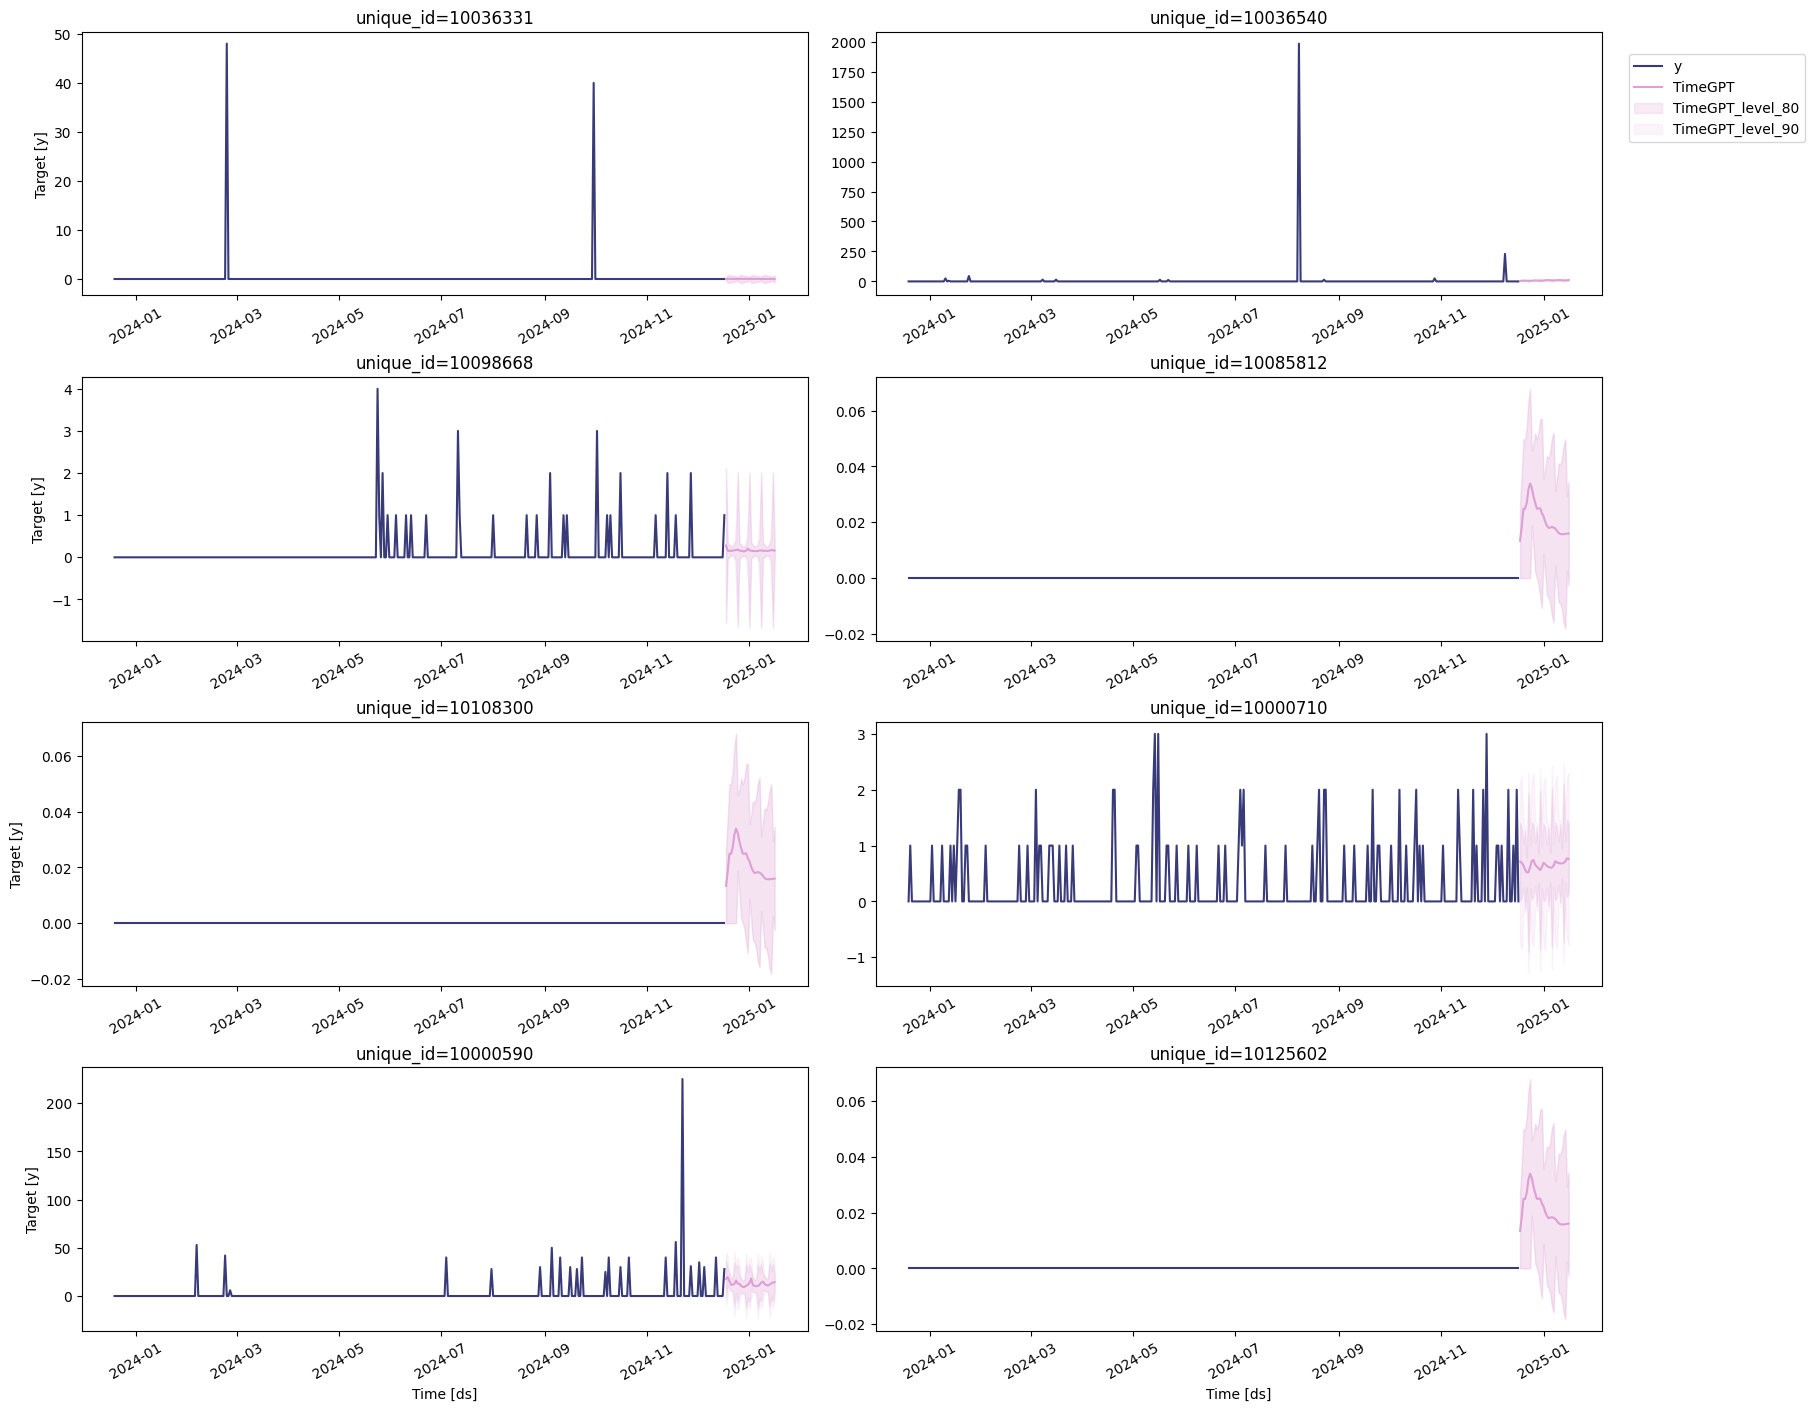

In [58]:
nixtla_client.plot(df, timegpt_fcst_multiseries_df, max_insample_length=365, level=[80, 90])

In [59]:
timegpt_fcst_multiseries_with_history_df = nixtla_client.forecast(df=df, h=30, level=[80, 90], add_history=True)
timegpt_fcst_multiseries_with_history_df.head()

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: D
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...
ERROR:nixtla.nixtla_client:Attempt 1 failed with error: The read operation timed out


,unique_id,ds,TimeGPT,TimeGPT-hi-80,TimeGPT-hi-90,TimeGPT-lo-80,TimeGPT-lo-90
0,10000033,2023-02-01,0.848493,4.618619,5.687398,-2.921633,-3.990411
1,10000033,2023-02-02,0.831278,4.601404,5.670182,-2.938848,-4.007626
2,10000033,2023-02-03,0.939500,4.709626,5.778404,-2.830626,-3.899404
3,10000033,2023-02-04,0.823318,4.593444,5.662222,-2.946808,-4.015586
4,10000033,2023-02-05,0.584130,4.354256,5.423034,-3.185996,-4.254775


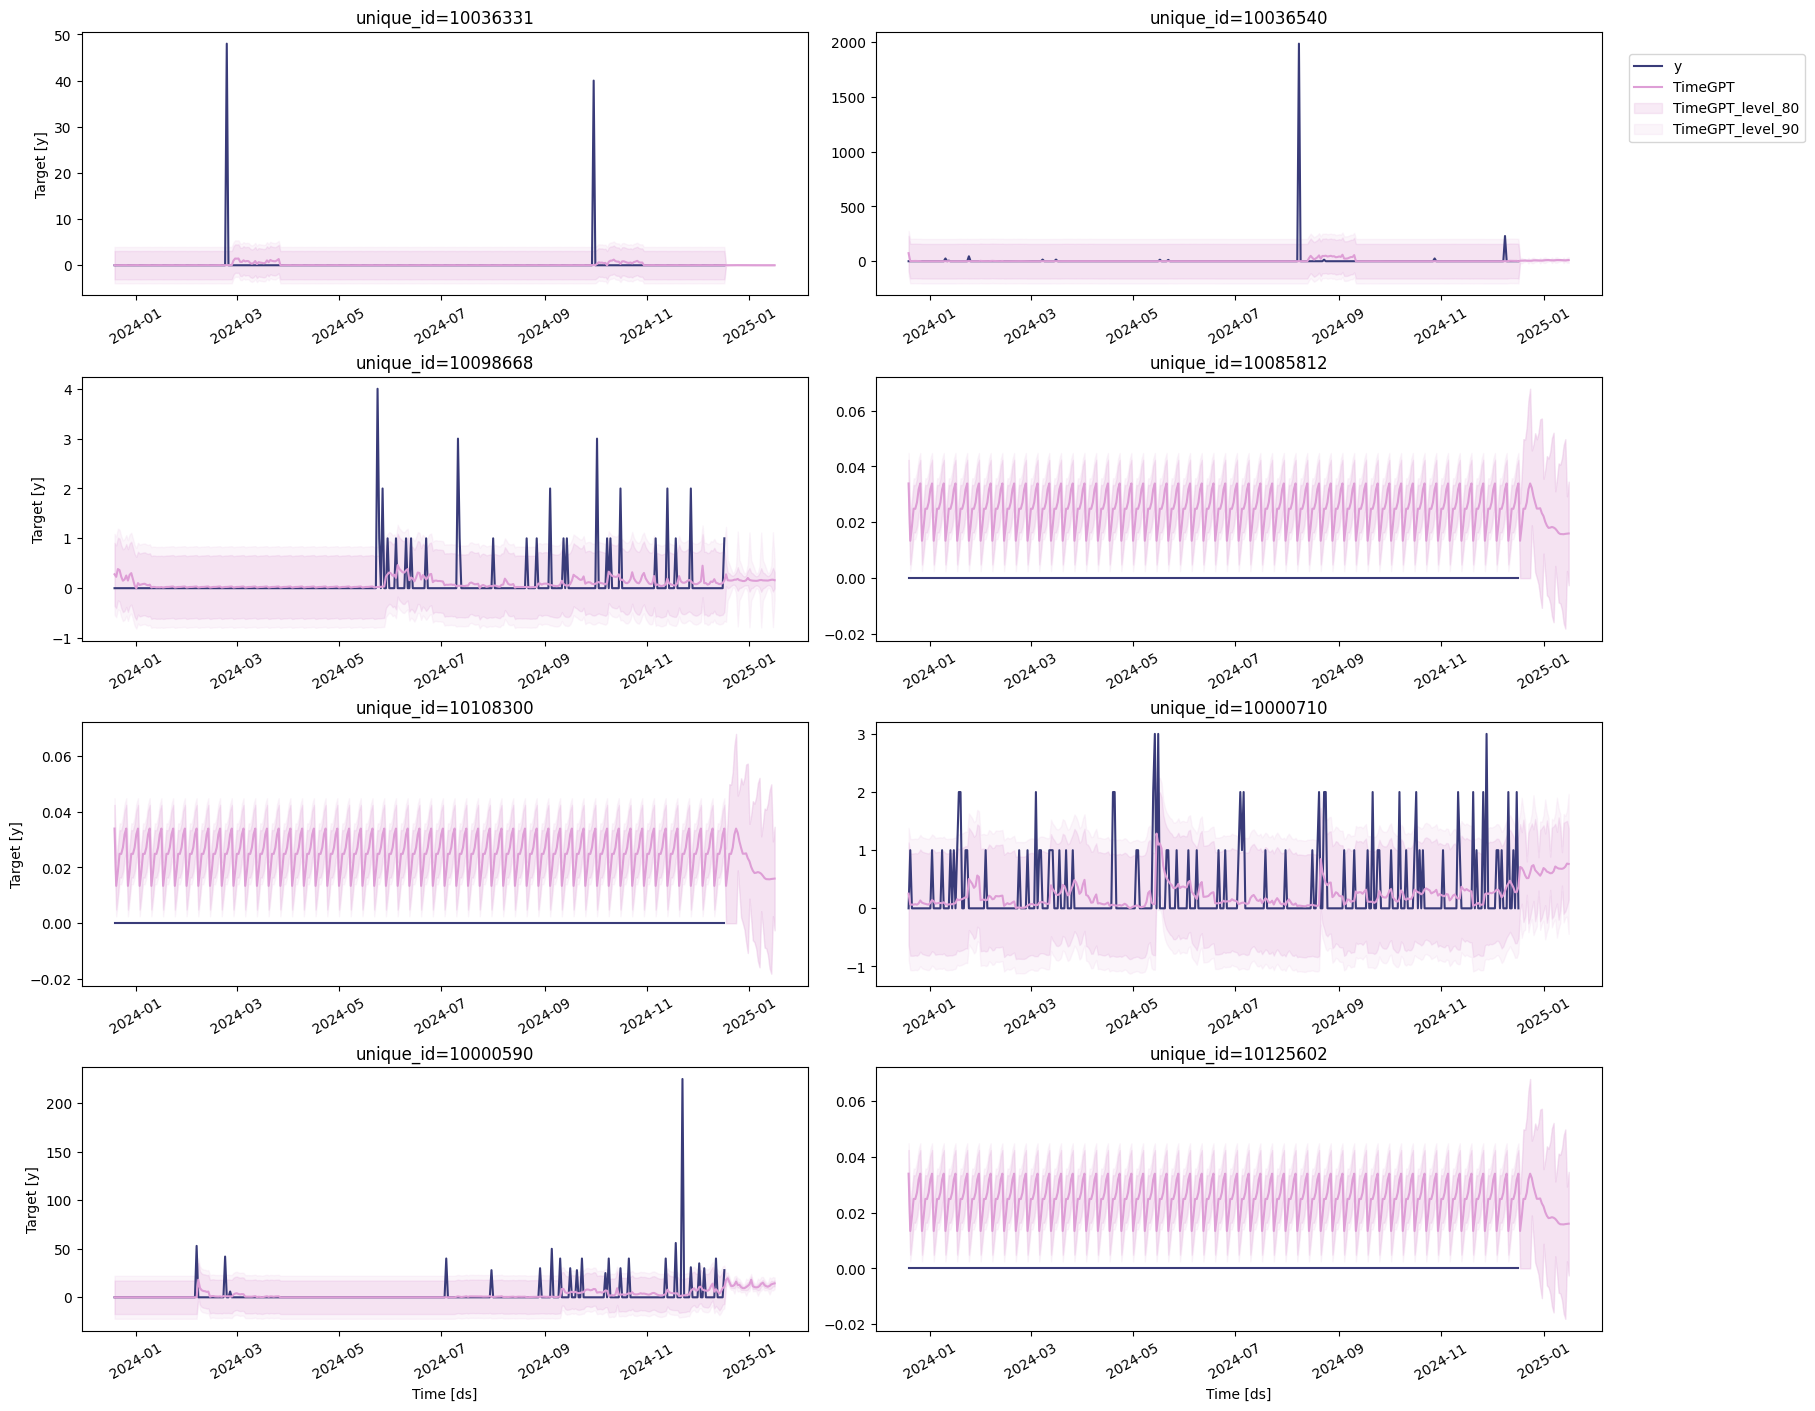

In [60]:
nixtla_client.plot(
    df, 
    timegpt_fcst_multiseries_with_history_df.groupby('unique_id').tail(365 + 30), 
    max_insample_length=365, 
    level=[80, 90],
)

## Exogeneous Variable

In [61]:
# Calculate Amount Issued and Amount Received
data['Amount Issued'] = data['Price'] * data['Material Issued']
data['Amount Received'] = data['Price'] * data['Material Received']

In [62]:
# Add 1-day Lag Feature
data['Lag_1_Issued'] = data.groupby('Material Code')['Material Issued'].shift(1)
data['Lag_1_Amount_Issued'] = data.groupby('Material Code')['Amount Issued'].shift(1)

# Add 7-day Rolling Statistics
data['Rolling_7_Issued'] = data.groupby('Material Code')['Material Issued'].rolling(7).mean().reset_index(level=0, drop=True)
data['Rolling_7_Amount_Issued'] = data.groupby('Material Code')['Amount Issued'].rolling(7).mean().reset_index(level=0, drop=True)


In [63]:
# Cumulative Features
data['Cumulative_Issued'] = data.groupby('Material Code')['Material Issued'].cumsum()
data['Cumulative_Received'] = data.groupby('Material Code')['Material Received'].cumsum()
data['Cumulative_Amount_Issued'] = data.groupby('Material Code')['Amount Issued'].cumsum()

# Interaction Features
data['Price_Issued_Interaction'] = data['Price'] * data['Material Issued']

In [64]:
features = ['Date', 'Material Issued','Open Stock', 'Closing Stock', 'Material Code', 'Lag_1_Issued', 'Rolling_7_Issued', 'BFP', 'Lag_1_Amount_Issued', 'Rolling_7_Amount_Issued', 'Cumulative_Issued', 'Cumulative_Received', 'Cumulative_Amount_Issued', 'Price_Issued_Interaction']
df_1= data[features].copy()

In [65]:
df_1.rename({'Material Code': 'unique_id', 'Date': 'ds', 'Material Issued': 'y'}, inplace=True, axis=1)
df_1.head()

,ds,y,Open Stock,Closing Stock,unique_id,Lag_1_Issued,Rolling_7_Issued,BFP,Lag_1_Amount_Issued,Rolling_7_Amount_Issued,Cumulative_Issued,Cumulative_Received,Cumulative_Amount_Issued,Price_Issued_Interaction
8976,2023-01-01,0.0,1334.0,1334.0,10091532,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
8784,2023-01-01,0.0,74.0,74.0,10024373,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
8783,2023-01-01,0.0,42.0,42.0,10024372,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
8782,2023-01-01,0.0,0.0,0.0,10024297,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
8772,2023-01-01,0.0,1140.0,1140.0,10023865,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0


In [66]:
df_1 = df_1.dropna()

In [67]:
exog_features = list(df_1.columns)
exog_features.remove('y')
exog_df = df_1[exog_features]

In [68]:
exog_df.head()

,ds,Open Stock,Closing Stock,unique_id,Lag_1_Issued,Rolling_7_Issued,BFP,Lag_1_Amount_Issued,Rolling_7_Amount_Issued,Cumulative_Issued,Cumulative_Received,Cumulative_Amount_Issued,Price_Issued_Interaction
5187,2023-01-07,0.0,0.0,10136730,0.0,0.000000,0,0.00,0.000000,0.0,0.0,0.00,0.0
5186,2023-01-07,0.0,0.0,10136729,0.0,0.000000,0,0.00,0.000000,0.0,0.0,0.00,0.0
4259,2023-01-07,733.0,733.0,10000304,2.0,0.285714,0,2556.14,365.162857,2.0,0.0,2556.14,0.0
4933,2023-01-07,25.0,25.0,10102136,0.0,0.000000,0,0.00,0.000000,0.0,0.0,0.00,0.0
4935,2023-01-07,0.0,0.0,10102978,0.0,0.000000,0,0.00,0.000000,0.0,0.0,0.00,0.0


In [69]:
timegpt_fcst_ex_vars_df = nixtla_client.forecast(df=df_1, hist_exog_list=exog_features, h=30, level=[80, 90])
timegpt_fcst_ex_vars_df.head()


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: D
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using historical exogenous features: ['ds', 'Open Stock', 'Closing Stock', 'unique_id', 'Lag_1_Issued', 'Rolling_7_Issued', 'BFP', 'Lag_1_Amount_Issued', 'Rolling_7_Amount_Issued', 'Cumulative_Issued', 'Cumulative_Received', 'Cumulative_Amount_Issued', 'Price_Issued_Interaction']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


,unique_id,ds,TimeGPT,TimeGPT-hi-80,TimeGPT-hi-90,TimeGPT-lo-80,TimeGPT-lo-90
0,10000033,2024-12-18,1.232008,3.141861,4.526346,-0.677845,-2.062331
1,10000033,2024-12-19,4.402855,6.025952,6.514632,2.779758,2.291078
2,10000033,2024-12-20,0.482345,1.845003,2.219289,-0.880313,-1.254599
3,10000033,2024-12-21,1.424027,3.096275,3.690140,-0.248222,-0.842087
4,10000033,2024-12-22,0.578227,1.488852,1.765699,-0.332399,-0.609245


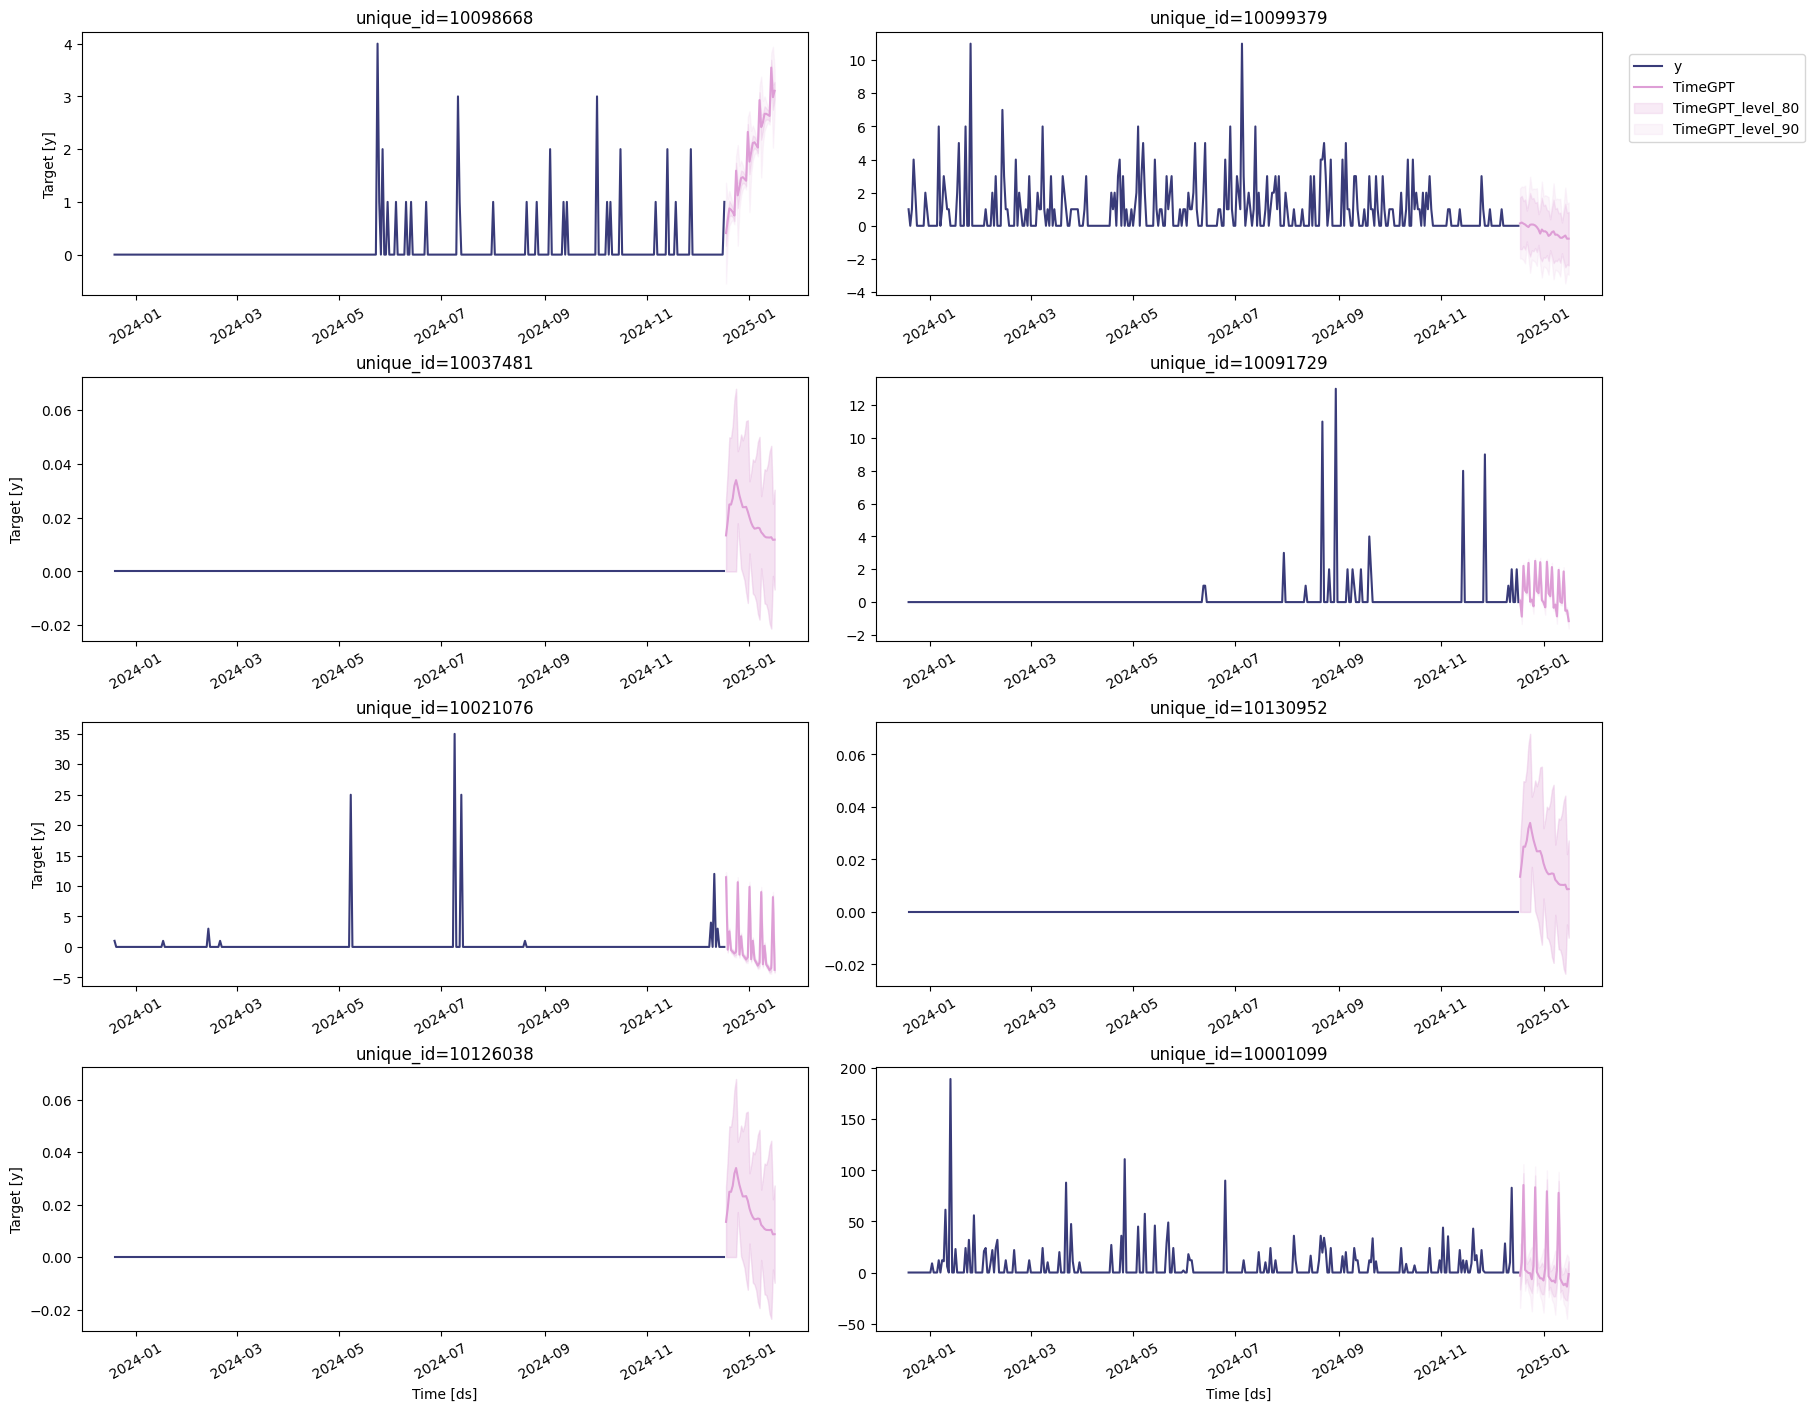

In [70]:
nixtla_client.plot(
    df_1[['unique_id', 'ds', 'y']], 
    timegpt_fcst_ex_vars_df, 
    max_insample_length=365, 
    level=[80, 90], 
)

<Axes: ylabel='features'>

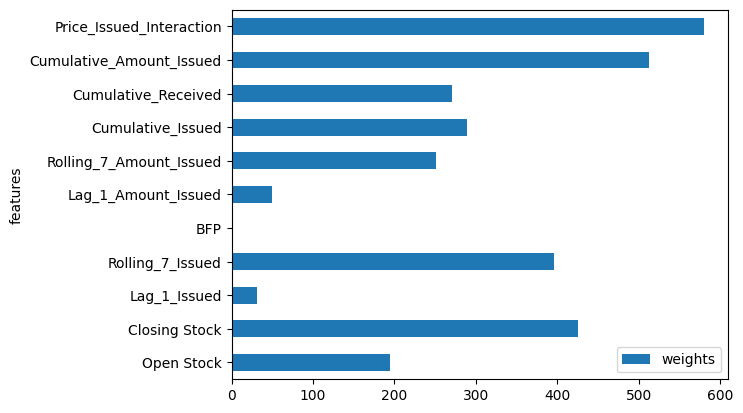

In [71]:
nixtla_client.weights_x.plot.barh(x='features', y='weights')

In [72]:
df_2=data[features].copy()

In [73]:
df_2.rename({'Material Code': 'unique_id', 'Date': 'ds', 'Material Issued': 'y'}, inplace=True, axis=1)
df_2.head()

,ds,y,Open Stock,Closing Stock,unique_id,Lag_1_Issued,Rolling_7_Issued,BFP,Lag_1_Amount_Issued,Rolling_7_Amount_Issued,Cumulative_Issued,Cumulative_Received,Cumulative_Amount_Issued,Price_Issued_Interaction
8976,2023-01-01,0.0,1334.0,1334.0,10091532,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
8784,2023-01-01,0.0,74.0,74.0,10024373,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
8783,2023-01-01,0.0,42.0,42.0,10024372,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
8782,2023-01-01,0.0,0.0,0.0,10024297,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
8772,2023-01-01,0.0,1140.0,1140.0,10023865,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0


In [74]:
df_2 = df_2.dropna()

In [75]:
exog_features = list(df_1.columns)
exog_features.remove('y')
exog_df = df_1[exog_features]

In [76]:
exog_df.head()

,ds,Open Stock,Closing Stock,unique_id,Lag_1_Issued,Rolling_7_Issued,BFP,Lag_1_Amount_Issued,Rolling_7_Amount_Issued,Cumulative_Issued,Cumulative_Received,Cumulative_Amount_Issued,Price_Issued_Interaction
5187,2023-01-07,0.0,0.0,10136730,0.0,0.000000,0,0.00,0.000000,0.0,0.0,0.00,0.0
5186,2023-01-07,0.0,0.0,10136729,0.0,0.000000,0,0.00,0.000000,0.0,0.0,0.00,0.0
4259,2023-01-07,733.0,733.0,10000304,2.0,0.285714,0,2556.14,365.162857,2.0,0.0,2556.14,0.0
4933,2023-01-07,25.0,25.0,10102136,0.0,0.000000,0,0.00,0.000000,0.0,0.0,0.00,0.0
4935,2023-01-07,0.0,0.0,10102978,0.0,0.000000,0,0.00,0.000000,0.0,0.0,0.00,0.0


In [77]:
timegpt_fcst_ex_vars_df = nixtla_client.forecast(df=df_1, hist_exog_list=exog_features, h=30, level=[80, 90], feature_contributions=True)
timegpt_fcst_ex_vars_df.head()


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: D
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using historical exogenous features: ['ds', 'Open Stock', 'Closing Stock', 'unique_id', 'Lag_1_Issued', 'Rolling_7_Issued', 'BFP', 'Lag_1_Amount_Issued', 'Rolling_7_Amount_Issued', 'Cumulative_Issued', 'Cumulative_Received', 'Cumulative_Amount_Issued', 'Price_Issued_Interaction']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


,unique_id,ds,TimeGPT,TimeGPT-hi-80,TimeGPT-hi-90,TimeGPT-lo-80,TimeGPT-lo-90
0,10000033,2024-12-18,1.231942,3.141668,4.526241,-0.677784,-2.062357
1,10000033,2024-12-19,4.402790,6.025738,6.514568,2.779842,2.291012
2,10000033,2024-12-20,0.482304,1.844925,2.219371,-0.880317,-1.254763
3,10000033,2024-12-21,1.423990,3.096153,3.689893,-0.248172,-0.841913
4,10000033,2024-12-22,0.578205,1.488774,1.765791,-0.332364,-0.609381


In [78]:
material_list=data['Material Code'].unique()
material=material_list[0]

In [79]:
shap_df = nixtla_client.feature_contributions
shap_df = shap_df.query("unique_id == @material")
shap_df.head()

,unique_id,ds,TimeGPT,Open Stock,Closing Stock,Lag_1_Issued,Rolling_7_Issued,BFP,Lag_1_Amount_Issued,Rolling_7_Amount_Issued,Cumulative_Issued,Cumulative_Received,Cumulative_Amount_Issued,Price_Issued_Interaction,base_value
9630,10091532,2024-12-18,-1.449864,0.234525,-1.449218,-0.000975,-0.558971,0.0,0.033544,-0.094119,-0.528261,-0.039992,-5.075828,7.033817,-1.004386
9631,10091532,2024-12-19,-1.087290,0.234525,-1.449218,-0.000975,-0.558971,0.0,0.033544,-0.094119,-0.528261,-0.039992,-5.075828,7.033817,-0.641813
9632,10091532,2024-12-20,0.909033,0.234525,-1.449218,-0.000975,-0.558971,0.0,0.033544,-0.094119,-0.528261,-0.039992,-5.075828,7.033817,1.354510
9633,10091532,2024-12-21,3.381963,0.234525,-1.449218,-0.000975,-0.558971,0.0,0.033544,-0.094119,-0.528261,-0.039992,-5.075828,7.033817,3.827441
9634,10091532,2024-12-22,1.305960,0.234525,-1.449218,-0.000975,-0.558971,0.0,0.033544,-0.094119,-0.528261,-0.039992,-5.075828,7.033817,1.751438


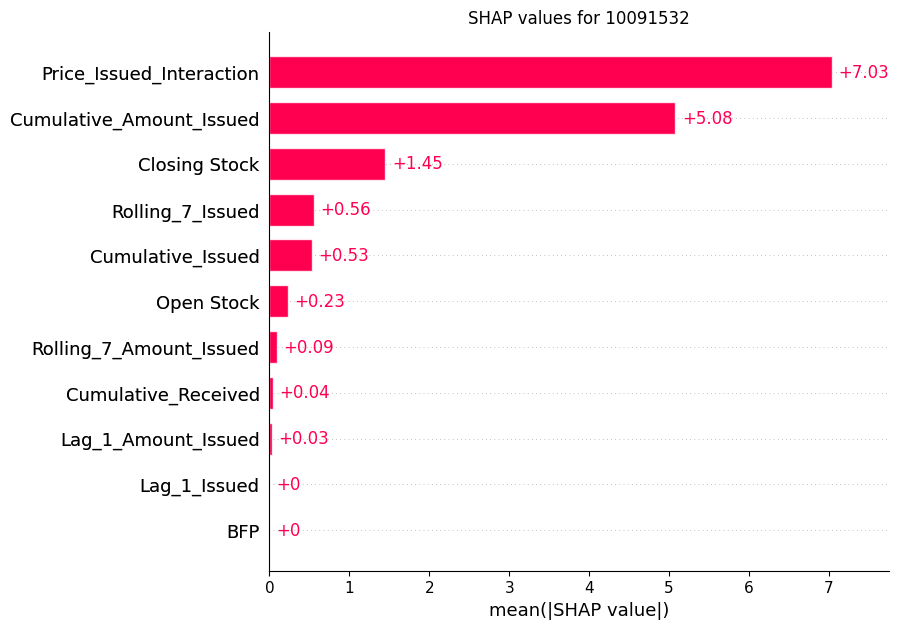

In [80]:
shap_columns = shap_df.columns.difference(['unique_id', 'ds', 'TimeGPT', 'base_value'])
shap_values = shap_df[shap_columns].values  # SHAP values matrix
base_values = shap_df['base_value'].values  # Extract base values
features = shap_columns  # Feature names

# Create a SHAP values object
shap_obj = shap.Explanation(values=shap_values, base_values=base_values, feature_names=features)

# Plot the bar plot for SHAP values
shap.plots.bar(shap_obj, max_display=len(features), show=False)
plt.title(f'SHAP values for {material}')
plt.show()


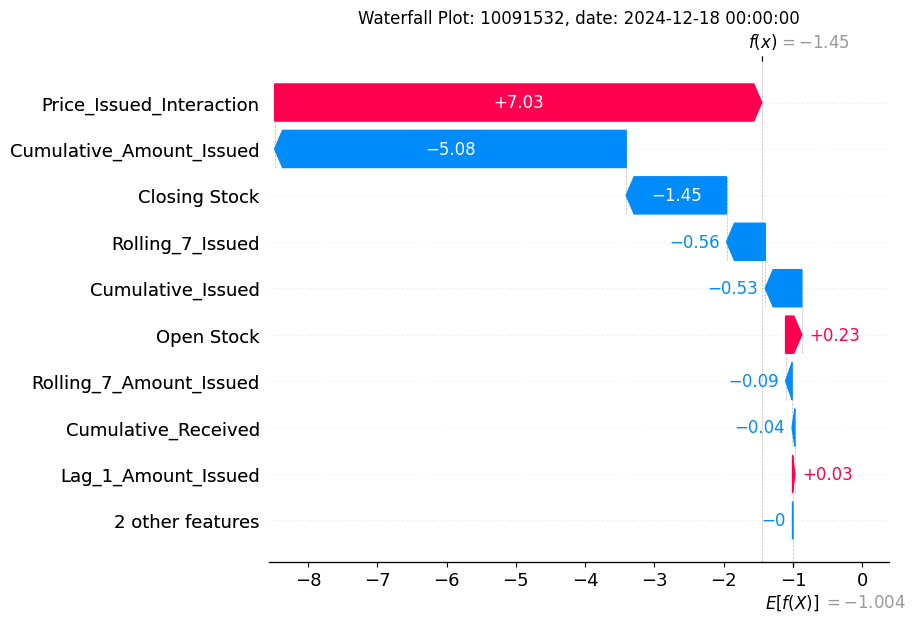

In [81]:
selected_ds = shap_df['ds'].min()

filtered_df = shap_df[shap_df['ds'] == selected_ds]

shap_values = filtered_df[shap_columns].values.flatten()
base_value = filtered_df['base_value'].values[0]
features = shap_columns

shap_obj = shap.Explanation(values=shap_values, base_values=base_value, feature_names=features)

shap.plots.waterfall(shap_obj, show=False)
plt.title(f'Waterfall Plot: {material}, date: {selected_ds}')
plt.show()


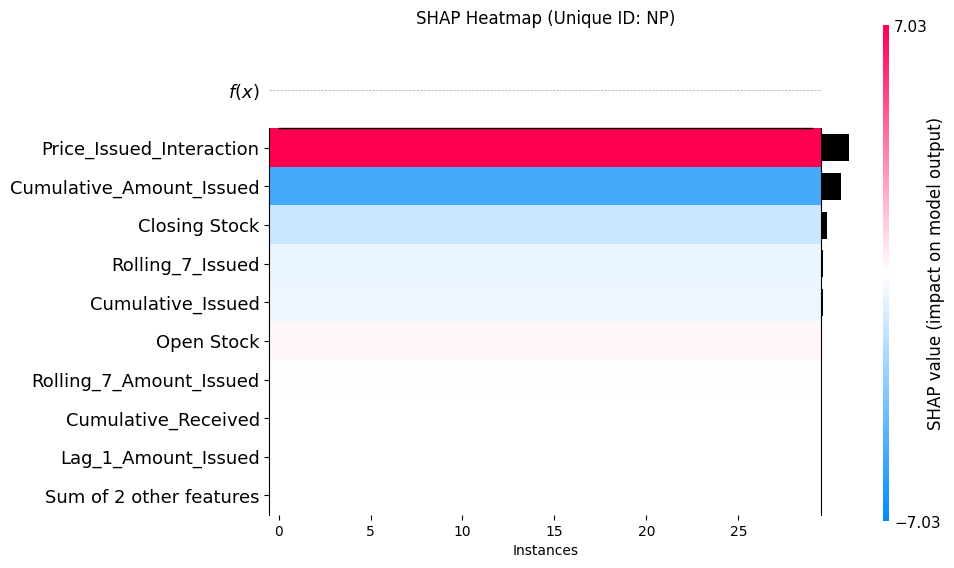

In [82]:
shap_columns = shap_df.columns.difference(['unique_id', 'ds', 'TimeGPT', 'base_value'])
shap_values = shap_df[shap_columns].values  
feature_names = shap_columns.tolist()

shap_obj = shap.Explanation(values=shap_values, feature_names=feature_names)

shap.plots.heatmap(shap_obj, show=False)
plt.title(f'SHAP Heatmap (Unique ID: NP)')
plt.show()


In [83]:
data_frame=data[['Date', 'Material Code', 'Material Issued']].copy()
data_frame.rename({'Material Code': 'unique_id', 'Date': 'ds', 'Material Issued': 'y'}, inplace=True, axis=1)
data_frame.head()

,ds,unique_id,y
8976,2023-01-01,10091532,0.0
8784,2023-01-01,10024373,0.0
8783,2023-01-01,10024372,0.0
8782,2023-01-01,10024297,0.0
8772,2023-01-01,10023865,0.0


In [84]:
# Get unique material codes 
material_codes = data_frame['unique_id'].unique()

# Create a dictionary to hold DataFrames for each material code
material_data = {material: data_frame[data_frame['unique_id'] == material] for material in material_codes}

In [ ]:
# Hyperparameter tuning for each material code
for material, df in tqdm(material_data.items(), total=len(material_data), desc="Processing Material Codes"):
    # Drop missing values
    df = df.dropna()
    if df.empty:
        print(f"No data available for material {material}")
        continue

    train = df[:-60]
    test = df[-60:]

    losses = ['default', 'mae', 'mse', 'rmse', 'mape', 'smape']

    test = test.copy()

    for loss in losses:
        preds_df = nixtla_client.forecast(
        df=train, 
        h=60, 
        finetune_steps=10,
        finetune_loss=loss)
    
        preds = preds_df['TimeGPT'].values
    
        test.loc[:,f'TimeGPT_{loss}'] = preds
    test.to_csv(f'../results/timegpt/test_results_{material}.csv', index=False)

Processing Material Codes:   0%|          | 0/642 [00:00<?, ?it/s]

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: D
INFO:nixtla.nixtla_client:Preprocessing dataframes...


INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: D
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: D
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: D
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: D
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: D
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:

KeyboardInterrupt: 

In [95]:
import os
import pandas as pd
from utilsforecast.losses import mae, mse, rmse, mape, smape

# Define loss functions
loss_fct_dict = {
    "mae": mae,
    "mse": mse,
    "rmse": rmse,
    "mape": mape,
    "smape": smape
}

# Define the directory containing the CSV files
folder_path = '../results/timegpt/'

# Initialize a list to store results
results = []

# Iterate through each file in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)
        
        # Read the CSV file
        test = pd.read_csv(file_path)
        
        # Compute percentage improvements
        pct_improv = {}
        pct_improv['file'] = file_name
        for loss in losses[1:]:
            evaluation = loss_fct_dict[f'{loss}'](
                test, 
                models=['TimeGPT_default', f'TimeGPT_{loss}'], 
                id_col='unique_id', 
                target_col='y'  # Target column is 'y'
            )
            pct_diff = (
                (evaluation['TimeGPT_default'] - evaluation[f'TimeGPT_{loss}']) 
                / evaluation['TimeGPT_default']
            ) * 100
            # Extract scalar value from Series
            pct_improv[loss] = round(pct_diff.values[0], 2) if not pct_diff.empty else None
        
        # Append results for this file
        results.append(pct_improv)



In [96]:
# Convert results into a DataFrame
metrics_df = pd.DataFrame(results)

# Print or save the metrics DataFrame
display(metrics_df)

# Optionally, save the results to a CSV file
metrics_df.to_csv('../results/timegpt/analysis/percentage_improvement_summary.csv', index=False)

,file,mae,mse,rmse,mape,smape
0,test_results_10001843.csv,47.21,23.96,21.40,NaN,0.00
1,test_results_10113816.csv,53.40,-171.90,-58.98,NaN,0.00
2,test_results_10119490.csv,31.84,-471.56,-143.53,-670.76,-8.33
3,test_results_10001086.csv,1.61,-112.34,-55.59,-4.83,-1.22
4,test_results_10101991.csv,34.16,-8.25,-4.10,35.99,-4.26
...,...,...,...,...,...,...
637,test_results_10109571.csv,53.40,0.06,61.08,NaN,0.00
638,test_results_10107721.csv,53.40,0.06,61.08,NaN,0.00
639,test_results_10024372.csv,10.55,-0.62,-0.38,-0.96,-0.05
640,test_results_10099475.csv,48.38,-5428.17,-647.19,47.46,6.44
